# Neural Network Model Comparison: Cross-Domain Performance Analysis

This notebook compares different CNN model training strategies for **fiber orientation prediction**, evaluating how well each approach generalizes to an **unseen biological test set**.

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../../src'))

# Import from our package
from fiber_predictor.neural_networks.data_processing import load_dataset
from fiber_predictor.neural_networks.model import CNN
from fiber_predictor.utils.split_utils import split_dataset_temp

In [ ]:
model_params = {
    'in_channels': 1, 
    'conv_channels': [32, 64, 128],
    'pool_kernel': 2, 
    'activation': nn.ReLU, 
    'dropout': 0.2, 
    'fc_dims': [128, 64], 
    'output_dim': 1
}


model = CNN(**model_params)

summary(model, (1, 50, 50))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
AdaptiveAvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
             ReLU-14                  [

## 0. Configuration & Data Splitting

Before training, we define configuration settings and split the biological dataset into training and testing directories to ensure:

- **Parameter Consistency**: The `config` dictionary centralizes key settings like image size, batch size, and learning parameters
- **Isolated Testing**: Using `split_dataset_temp`, we set aside 20% of biological images for final evaluation

In [ ]:
# Paths
IMAGE_DIR = '../../images'
MODEL_DIR = '../../models/cnn'
os.makedirs(MODEL_DIR, exist_ok=True)

# Model/Training Parameters
config = {
    'image_size': (50, 50),  # Standard input size
    'batch_size': 32,
    'learning_rate': 5e-5,
    'epochs': 50,
    'device': torch.device('mps' if torch.mps.is_available() else 'cpu')
}

print(f"Using device: {config['device']}")

Using device: mps


In [5]:
# Physically split the BIO dataset for testing
bio_orig_folder = os.path.join(IMAGE_DIR, "bio")
bio_temp, (bio_train_folder, bio_train_csv), (bio_test_folder, bio_test_csv) = split_dataset_temp(
    bio_orig_folder,
    labels_csv_name="labels.csv",
    test_size=0.2,
    random_seed=42
)

# Dataset paths
bio_file_dir = bio_train_folder
bio_csv_dir = bio_train_csv
diff_file_dir = os.path.join(IMAGE_DIR, "diffusion/")
diff_csv_dir = os.path.join(IMAGE_DIR, "diffusion/labels.csv")

Dataset split into temp folder: /var/folders/xm/27vmbv710jlb_sbsxw58p3nh0000gn/T/tmp5d_soyos
 Train folder: /var/folders/xm/27vmbv710jlb_sbsxw58p3nh0000gn/T/tmp5d_soyos/train  (538 images)
 Test folder : /var/folders/xm/27vmbv710jlb_sbsxw58p3nh0000gn/T/tmp5d_soyos/test   (135 images)



## 1. Data Loading and Initial Processing

We load and prepare our datasets with different preprocessing strategies:

1. Raw datasets (no augmentation/balancing)
2. Balanced datasets (upsampled for angle uniformity)
3. Augmented datasets (with random transformations)
4. Combined datasets (bio + diffusion)

In [6]:
# Load all training datasets
print("Loading training datasets...")

# Bio datasets
bio_raw = load_dataset(bio_file_dir, bio_csv_dir, config)
bio_balanced = load_dataset(bio_file_dir, bio_csv_dir, config, balance=True)
bio_aug = load_dataset(bio_file_dir, bio_csv_dir, config, augment=True)
bio_aug_balanced = load_dataset(bio_file_dir, bio_csv_dir, config, augment=True, balance=True)

# Diffusion datasets
diff_raw = load_dataset(diff_file_dir, diff_csv_dir, config)
diff_balanced = load_dataset(diff_file_dir, diff_csv_dir, config, balance=True)
diff_aug = load_dataset(diff_file_dir, diff_csv_dir, config, augment=True)
diff_aug_balanced = load_dataset(diff_file_dir, diff_csv_dir, config, augment=True, balance=True)

# Combined datasets
def combine_datasets(dataset1, dataset2):
    return {
        'images': torch.cat([dataset1['images'], dataset2['images']]),
        'labels': torch.cat([dataset1['labels'], dataset2['labels']]),
        'n_samples': dataset1['n_samples'] + dataset2['n_samples']
    }

combined_raw = combine_datasets(bio_raw, diff_raw)
combined_balanced = combine_datasets(bio_balanced, diff_balanced)
combined_aug = combine_datasets(bio_aug, diff_raw)
combined_aug_balanced = combine_datasets(bio_aug_balanced, diff_aug_balanced)

# Load test dataset
print("Loading test dataset...")
bio_test = load_dataset(bio_test_folder, bio_test_csv, config)

# Print dataset sizes
print("\nDataset Sizes:")
print(f"Bio Test Set: {bio_test['n_samples']} samples")

print(f"\nBio Training Sets:")
print(f"Raw: {bio_raw['n_samples']} samples")
print(f"Balanced: {bio_balanced['n_samples']} samples")
print(f"Augmented(Inplace): {bio_aug['n_samples']} samples")
print(f"Augmented+Balanced: {bio_aug_balanced['n_samples']} samples")

print(f"\nDiffusion Training Sets:")
print(f"Raw: {diff_raw['n_samples']} samples")
print(f"Balanced: {diff_balanced['n_samples']} samples")
print(f"Augmented(Inplace): {diff_aug['n_samples']} samples")
print(f"Augmented+Balanced: {diff_aug_balanced['n_samples']} samples")

print(f"\nCombined Training Sets:")
print(f"Raw: {combined_raw['n_samples']} samples")
print(f"Balanced: {combined_balanced['n_samples']} samples")
print(f"Augmented(Inplace): {combined_aug['n_samples']} samples")
print(f"Augmented+Balanced: {combined_aug_balanced['n_samples']} samples")

# Initialize tracking DataFrame
tracking_data = []

Loading training datasets...
Loading test dataset...

Dataset Sizes:
Bio Test Set: 135 samples

Bio Training Sets:
Raw: 538 samples
Balanced: 99 samples
Augmented(Inplace): 538 samples
Augmented+Balanced: 99 samples

Diffusion Training Sets:
Raw: 609 samples
Balanced: 297 samples
Augmented(Inplace): 609 samples
Augmented+Balanced: 297 samples

Combined Training Sets:
Raw: 1147 samples
Balanced: 396 samples
Augmented(Inplace): 1147 samples
Augmented+Balanced: 396 samples


## 2. Model Training and Evaluation Function

This section defines our approach for training and evaluating each model configuration:

1. **CNN Architecture**: Uses our custom CNN model designed for angle prediction
2. **Training Loop**: Implements standard PyTorch training with early stopping
3. **Evaluation**: Measures Mean Absolute Error (MAE) on train, validation, and test sets

In [7]:
def train_evaluate_model(train_dataset, test_dataset, model_params=None, model_name=None):
    # Split training data
    train_images = train_dataset['images']
    train_labels = train_dataset['labels']
    
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_labels,
        test_size=0.2,
        random_state=42
    )
    
    # Create data loaders
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),  # Add channel dimension to labels
        batch_size=config['batch_size'],
        shuffle=True
    )
    
    val_loader = DataLoader(
        TensorDataset(X_val, y_val),  # Add channel dimension to labels
        batch_size=config['batch_size']
    )
    
    test_loader = DataLoader(
        TensorDataset(test_dataset['images'], test_dataset['labels']),  # Add channel dimension to labels
        batch_size=config['batch_size']
    )
    
    # Initialize model
    if model_params:
        model = CNN(**model_params).to(config['device'])
    else:
        model = CNN().to(config['device'])

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    # Dictionary to keep track of metrics each epoch
    training_log = {
        'train_loss': [],
        'val_loss': []
    }
    
    # Training loop
    for epoch in range(config['epochs']):
        model.train()
        for images, labels in train_loader:
            images = images.to(config['device'])
            labels = labels.to(config['device'])
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(config['device'])
                labels = labels.to(config['device'])
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
        
        val_loss /= len(val_loader)

        if (epoch+1) % 2 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{config['epochs']}:", end=' ')
            print(f"Train MSE Loss: {loss.item():.4f}, Validation MSE Loss: {val_loss:.4f}")
        
        training_log['train_loss'].append(loss.item())
        training_log['val_loss'].append(val_loss)

    # Evaluation
    model.eval()
    
    def evaluate_loader(loader):
        preds = []
        trues = []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(config['device'])
                outputs = model(images)
                preds.extend(outputs.cpu().numpy().squeeze())
                trues.extend(labels.numpy().squeeze())
        return mean_absolute_error(trues, preds)
    
    train_mae = evaluate_loader(train_loader)
    val_mae = evaluate_loader(val_loader)
    test_mae = evaluate_loader(test_loader)
    
    print(f"Train Set Performance:")
    print(f"MAE: {train_mae:.2f}°")
    
    print(f"Validation Set Performance:")
    print(f"MAE: {val_mae:.2f}°")
    
    print(f"Test Set Performance:")
    print(f"MAE: {test_mae:.2f}°")
    
    # Track results
    result = {
        'model_name': model_name,
        'training_data': model_name.split('_')[0],
        'approach': '_'.join(model_name.split('_')[1:]),
        'n_train': len(X_train),
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
    }
    
    tracking_data.append(result)

    # Save model
    model_path = os.path.join(MODEL_DIR, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)
    
    return model, training_log

## 3. Training and Evaluation Scenarios

We systematically train and evaluate models for each data configuration:

1. Bio-only models
2. Diffusion-only models
3. Combined (Bio + Diff) models

Each source is trained with different preprocessing approaches.

In [8]:
# Define dataset configurations
datasets = {
    'bio': {
        'raw': bio_raw,
        'balanced': bio_balanced,
        'augmented': bio_aug,
        'augmented_balanced': bio_aug_balanced,
    },
    'diff': {
        'raw': diff_raw,
        'balanced': diff_balanced,
        'augmented': diff_aug,
        'augmented_balanced': diff_aug_balanced,
    },
    'combined': {
        'raw': combined_raw,
        'balanced': combined_balanced,
        'augmented': combined_aug,
        'augmented_balanced': combined_aug_balanced,
    }
}

# Dictionary to store trained models
models = {}

# Train all models
for source, approaches in datasets.items():
    print(f"{'=' * 30}")
    print(f"Training {source.upper()}-based models:")
    print(f"{'=' * 30}")
    
    for approach, data in approaches.items():
        model_name = f"{source}_{approach}"
        print(f"Training {approach} {source} model...")
        
        model, logs = train_evaluate_model(
            data,
            bio_test,
            model_name=model_name
        )
        
        models[model_name] = model
        print(f"Model '{model_name}' trained and evaluated.\n")


Training BIO-based models:
Training raw bio model...
Epoch 1/50: Train MSE Loss: 2683.8271, Validation MSE Loss: 2829.2255
Epoch 2/50: Train MSE Loss: 3022.5366, Validation MSE Loss: 2826.3788
Epoch 4/50: Train MSE Loss: 3151.0613, Validation MSE Loss: 2820.8628
Epoch 6/50: Train MSE Loss: 1942.4128, Validation MSE Loss: 2811.8380
Epoch 8/50: Train MSE Loss: 2513.4050, Validation MSE Loss: 2792.8537
Epoch 10/50: Train MSE Loss: 2619.8188, Validation MSE Loss: 2735.2003
Epoch 12/50: Train MSE Loss: 2160.2566, Validation MSE Loss: 2649.4839
Epoch 14/50: Train MSE Loss: 2967.7283, Validation MSE Loss: 2508.7217
Epoch 16/50: Train MSE Loss: 2092.8691, Validation MSE Loss: 2282.9887
Epoch 18/50: Train MSE Loss: 2278.6917, Validation MSE Loss: 2016.3262
Epoch 20/50: Train MSE Loss: 2948.8198, Validation MSE Loss: 1592.9172
Epoch 22/50: Train MSE Loss: 1574.9702, Validation MSE Loss: 1271.8474
Epoch 24/50: Train MSE Loss: 1148.0718, Validation MSE Loss: 1068.1402
Epoch 26/50: Train MSE Loss: 

## 4. Results Summary

We analyze the performance of all trained models on the biological test set, comparing:

1. Training data source (Bio vs. Diff vs. Combined)
2. Preprocessing approach effectiveness
3. Generalization to unseen biological samples

Model Performance Summary (sorted by test MAE):


,model_name,training_data,approach,n_train,train_mae,val_mae,test_mae
8,combined_raw,combined,raw,917,16.055175,17.911433,19.342490
0,bio_raw,bio,raw,430,21.808715,17.468950,22.805154
10,combined_augmented,combined,augmented,917,17.144021,17.749137,26.950882
4,diff_raw,diff,raw,487,22.353765,23.968616,27.056715
9,combined_balanced,combined,balanced,316,22.556369,27.005079,30.802639
2,bio_augmented,bio,augmented,430,24.966306,21.001838,30.938365
5,diff_balanced,diff,balanced,237,25.161920,24.208680,32.323506
6,diff_augmented,diff,augmented,487,21.064315,18.616112,32.949844
11,combined_augmented_balanced,combined,augmented_balanced,316,26.634548,21.013418,34.932288
7,diff_augmented_balanced,diff,augmented_balanced,237,30.403735,27.742867,36.779758


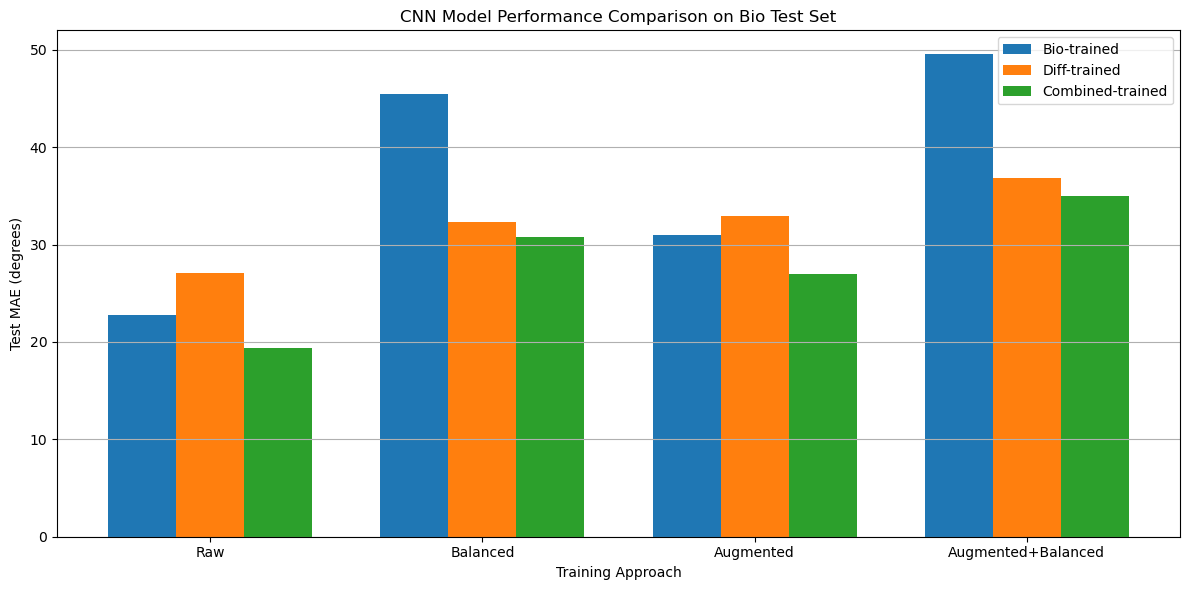

In [9]:
# Create summary DataFrame
summary_df = pd.DataFrame(tracking_data)

# Sort by test MAE to find best performing models
summary_df = summary_df.sort_values('test_mae')

# Display results
print("Model Performance Summary (sorted by test MAE):")
display(summary_df)

# Plot comparison
plt.figure(figsize=(12, 6))

# Create positions for bars
x = np.arange(4)  # raw, balanced, augmented, augmented+balanced

# Plot bars for each training data source
for i, source in enumerate(['bio', 'diff', 'combined']):
    source_data = summary_df[summary_df['training_data'] == source]
    
    # Get MAE values aligned by approach
    raw = source_data[source_data['approach'] == 'raw']['test_mae'].values
    balanced = source_data[source_data['approach'] == 'balanced']['test_mae'].values
    augmented = source_data[source_data['approach'] == 'augmented']['test_mae'].values
    augmented_balanced = source_data[source_data['approach'] == 'augmented_balanced']['test_mae'].values
    
    # Plot available approaches
    values = []
    if len(raw) > 0: values.append(raw[0])
    if len(balanced) > 0: values.append(balanced[0])
    if len(augmented) > 0: values.append(augmented[0])
    if len(augmented_balanced) > 0: values.append(augmented_balanced[0])
    
    plt.bar(x[:len(values)] + i*0.25, values, 0.25, label=f'{source.capitalize()}-trained')

plt.xlabel('Training Approach')
plt.ylabel('Test MAE (degrees)')
plt.title('CNN Model Performance Comparison on Bio Test Set')
plt.xticks(x + 0.25, ['Raw', 'Balanced', 'Augmented', 'Augmented+Balanced'])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Save summary to CSV
summary_df.to_csv(os.path.join(MODEL_DIR, 'model_comparison_summary.csv'), index=False)

### Conclusions

Through these experiments, we've evaluated:

- **Domain Transfer**: How well CNN models trained on one domain (diffusion) generalize to another (biology)
- **Data Enhancement**: Impact of balancing and augmentation on model performance
- **Combined Learning**: Whether merging domains improves prediction accuracy

These insights guide the selection of optimal training strategies for fiber orientation prediction using CNNs.